In [1]:
from duckduckgo_search import ddg_images
from typing import List, Dict, Any
from fastcore.all import *
from fastai.vision.widgets import *


In [2]:
imgs = ddg_images("shar pei", max_results=1)

In [3]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return ddg_images(term, max_results=max_images)

In [4]:
bear_types = ['grizzly','black','teddy']
path = Path('bears')

In [5]:
from fastai.vision import utils as vutils
from fastai.data.transforms import get_image_files



IMG_LIMIT = 300

path.mkdir(exist_ok=True)
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    fns = get_image_files(dest)
    if len(fns) >= IMG_LIMIT:
        continue
    search_results = search_images(f'{o} bear', max_images=(IMG_LIMIT - len(fns)))
    urls = [res["image"] for res in search_results]
    imgs = vutils.download_images(dest, urls=urls)

In [6]:
fns = get_image_files(path)

In [7]:
from fastai.vision import utils as vutils
failed = vutils.verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

In [9]:
from fastai.data import block, transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import RandomSplitter, Resize


bears = block.DataBlock(
    blocks=(ImageBlock, block.CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=transforms.parent_label,
    item_tfms=Resize(128))

In [10]:
dls = bears.dataloaders(path)

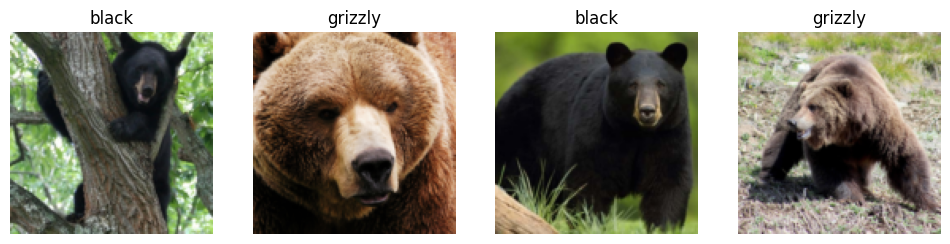

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

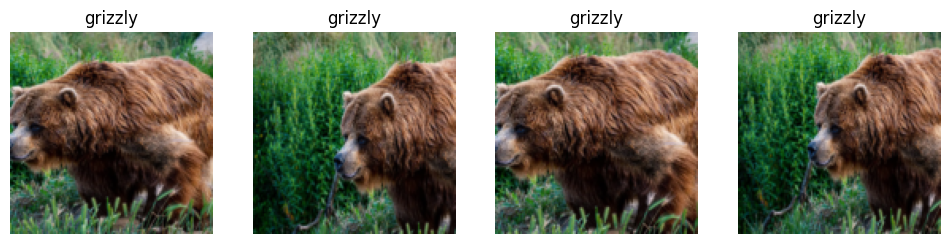

In [12]:
from fastai.vision.learner import Resize, RandomResizedCrop

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

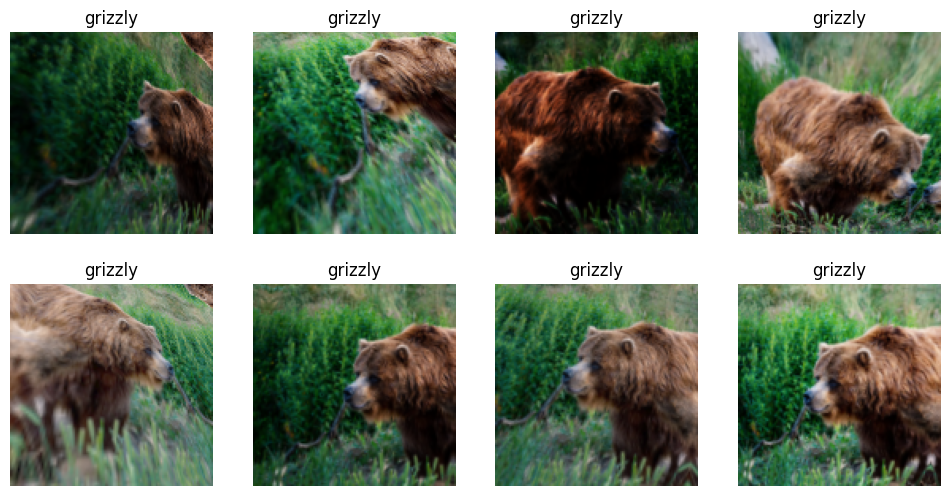

In [13]:
from fastai.vision.augment import aug_transforms

# Data Augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [14]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [15]:
from fastai.vision.learner import vision_learner
from fastai.vision.all import resnet18, error_rate

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/matt/.pyenv/versions/3.9.13/envs/jupyter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/matt/.pyenv/versions/3.9.13/envs/jupyter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/matt/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,0.895106,0.099489,0.038889,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.151300,0.076215,0.033333,00:17
1,0.116786,0.063916,0.022222,00:16
2,0.092991,0.066528,0.022222,00:16
3,0.075252,0.071187,0.022222,00:16


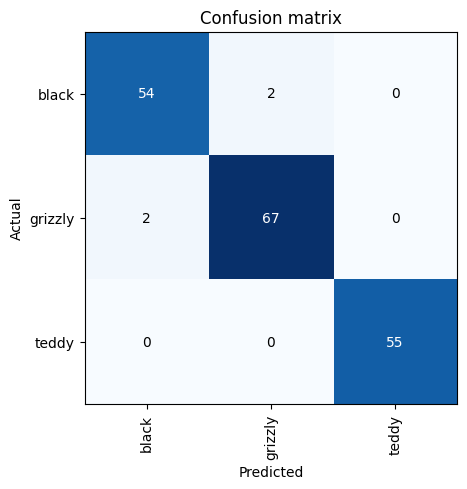

In [16]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

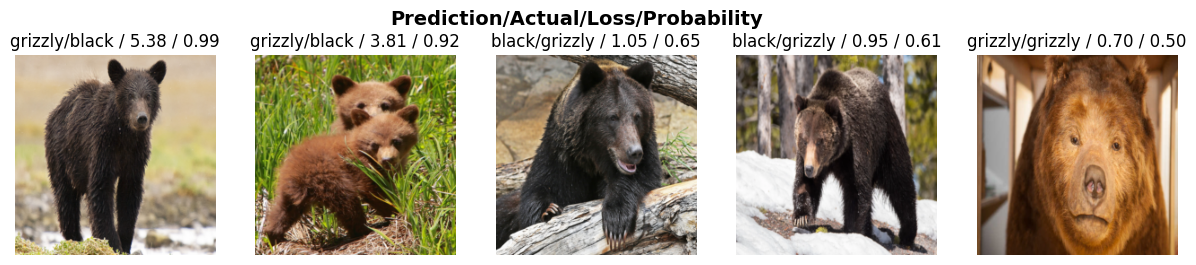

In [17]:
interp.plot_top_losses(5, nrows=1)

In [18]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
# Clearing out invalid data.
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# For moving data from one folder to another
# This assumes you're using the folder names as categories
for idx, category in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path / category)


In [20]:
learn.export()

/home/matt/.pyenv/versions/3.9.13/envs/jupyter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/matt/.pyenv/versions/3.9.13/envs/jupyter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.940698,0.065609,0.022222,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.108798,0.063448,0.022222,00:17
1,0.101021,0.082268,0.016667,00:16
2,0.096700,0.042520,0.016667,00:16
3,0.078842,0.039166,0.016667,00:17


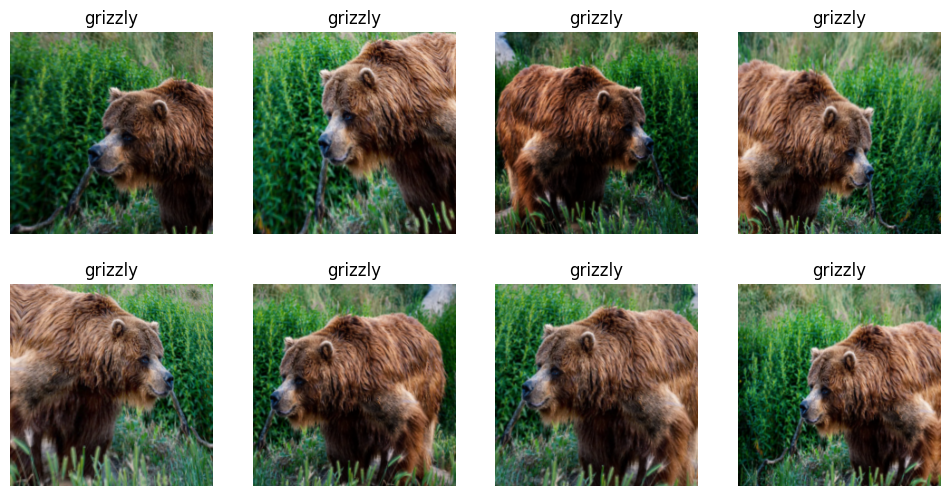

In [21]:
# retrain
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

# Actually using the model

In [22]:
learn.export()

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
from fastai.learner import load_learner
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('bears/black/feb76760-e1aa-4f53-aa74-ab72354023ff.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'bears/black/feb76760-e1aa-4f53-aa74-ab72354023ff.jpg'

In [ ]:
learn_inf.predict('bears/grizzly/79b20ad1-2f7e-4c00-baa0-c34c70365e46.jpg')

In [ ]:
learn_inf.dls.vocab